# Exploring Life Expectancy

## Section 1: Context and Problem Description
This analysis is focused on discovering the information about data expectancy from limited data. The data was imported from Data World Bank and each feature will be discussed in the next sections. The questions that the report will hopefully answer with quantitative argument and proper visualisation are below.

### Question 1: What is life expectancy throughout the years for selected countries? 

In this part, I want to show the visualisation of life expectancy of selected countries. I focused on the biggest ones, but also included country with biggest life expectancy, which is Switzerland or one of the poorest, which is Afghanistan. Besides, there will be included a union of countries, the EU. 
The selected coutries to analysis are : China, India,European Union, United States, Indonesia, Pakistan, Nigeria, Brazil, Bangladesh, Russian Federation, Mexico, Switzerland, Afghanistan.

### Question 2: What is the relation between the life expectancy and GDP per capita?

In the second question, I want to discover how the visualisation of life expectancy and GDP per capita, so the natural correlation, which comes to mind first looks like. For the analysis I will use the log of GDP per capita, because of scale of this feature for different countries.

### Question 3: What is the most correlated feature with life expectancy?

Next, I will analyse, which feature is most correlated with target value.

### Question 4: How well Machine Learning models can predict life expectancy?

Finally we will use and summarize the results of 3 ML models on our data to answer how good can model predict life expectancy on very limited data

## Section 2: Data Understanding 

Let's import  required libraries, data and have a look at it. Due to the slow data submitting on DWB, we will focuse on data to 2022, because for 2023 there are too much missing values.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


def import_data(data_path):
    data = pd.read_excel(data_path)
    data = data.rename(columns={"Atrybut" : "Year"})
    data = data[data['Year'] != 2023]
    data = data.drop(["Country Code"], axis = 1)
    return data

data = import_data("data_lexp.xlsx")

In [3]:
data.head(7)

,Country Name,Year,"Life expectancy at birth, total (years)",Population growth (annual %),"Population, total",Access to electricity (% of population),GDP per capita (current US$),Current health expenditure (% of GDP)
0,Afghanistan,2000,55.005,1.212176,20130327,4.4,174.930991,..
1,Afghanistan,2001,55.511,0.762005,20284307,9.3,138.706822,..
2,Afghanistan,2002,56.225,5.25203,21378117,14.1,178.954088,9.443391
3,Afghanistan,2003,57.171,6.145194,22733049,19,198.871116,8.941258
4,Afghanistan,2004,57.810,3.575835,23560654,23.8,221.763654,9.808474
5,Afghanistan,2005,58.247,3.519217,24404567,28.7,254.184249,9.948289
6,Afghanistan,2006,58.553,4.092702,25424094,33.5,274.218554,10.622766


Our data have in rows each country data from 2000 to 2022.

In [4]:
data_2022 = data[data["Year"] == 2022]
data_2022.head(5)

,Country Name,Year,"Life expectancy at birth, total (years)",Population growth (annual %),"Population, total",Access to electricity (% of population),GDP per capita (current US$),Current health expenditure (% of GDP)
22,Afghanistan,2022,65.617000,1.435704,40578842,85.3,357.261153,23.088169
46,Africa Eastern and Southern,2022,64.487020,2.592754,731821393,48.801258,1628.318944,5.72792
70,Africa Western and Central,2022,57.987813,2.33227,497387180,55.686683,1796.668633,4.209822
94,Albania,2022,78.769000,-1.21579,2777689,100,6846.426694,6.193681
118,Algeria,2022,76.129000,1.587582,45477389,100,4961.552577,3.623043


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5382 entries, 0 to 5614
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Country Name                             5382 non-null   object 
 1   Year                                     5382 non-null   int64  
 2   Life expectancy at birth, total (years)  5382 non-null   float64
 3   Population growth (annual %)             5382 non-null   object 
 4   Population, total                        5382 non-null   int64  
 5   Access to electricity (% of population)  5382 non-null   object 
 6   GDP per capita (current US$)             5382 non-null   object 
 7   Current health expenditure (% of GDP)    5382 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 378.4+ KB


To understand the data better, we should look at distribution. To do this we shoud handle the missing data first, because our missing values are not Nan type, but are "..".

## Section 3: Data Preparing
In this section we will handle missing values, which are labeled ".." in our data. At first I will drop coutries with the most missing values, they will not be important for our analysis, because they will be mostly the smallest ones. For the rest missing values I will try to fill the blanks with the proper value resulting from other values.

In [6]:
print((data == "..").sum())
print("The sum of missing values: ", (data == "..").sum().sum())

Country Name                                 0
Year                                         0
Life expectancy at birth, total (years)      0
Population growth (annual %)                 1
Population, total                            0
Access to electricity (% of population)     71
GDP per capita (current US$)               161
Current health expenditure (% of GDP)      653
dtype: int64
The sum of missing values:  886


In [7]:
data['empty_values'] = (data == "..").sum(axis=1)
countries_to_delete = data.groupby("Country Name")["empty_values"].sum().sort_values(ascending =False)[0:32].index.to_numpy()
data = data[~data["Country Name"].isin(countries_to_delete)]
(data == "..").sum()

Country Name                               0
Year                                       0
Life expectancy at birth, total (years)    0
Population growth (annual %)               1
Population, total                          0
Access to electricity (% of population)    2
GDP per capita (current US$)               6
Current health expenditure (% of GDP)      9
empty_values                               0
dtype: int64

We can see that dropping 32 countries, which are mostly micro-states, which are not as important as other countries dropped the number of missing values from 886 to only 18, which can be handled by filling.

We will handle missing values with linear regression due to the fact that features are growing approximately linearily. The idea is to fit linear regression model with not missing feature data and then predict the missing ones with fitted model.

In [8]:
# dealing with missing value with linear regression
def handling_data(data, country, feature):
    """
    function returns filled data with linear regression filling technic

    input: 
        data: data frame of our data
        country: choosen coutry we want to fill data
        feature: choosen feature we want to fill
    output:
        data: our data frame filled with new data in selected country and feature
    """
    values = data[data["Country Name"] == country][[feature]]
    miss_val_count = values.value_counts()[".."]
    
    #There is two situations in data. The missing data is on the beginning and end of time series.
    # So we have to find out which situations we are dealing with.
    min_idx = data[data["Country Name"] == country][[feature]].index.min()
    idx_list = data[data["Country Name"] == country][[feature]]
    idx_list = idx_list.index[idx_list[feature] == ".."]
    
    if (min_idx in idx_list):
        y = values[feature][miss_val_count:]
        X = np.arange(miss_val_count,len(values)).reshape(-1,1)
    
        lin_reg = LinearRegression().fit(X,y)
        model_result = lin_reg.predict(np.arange(0,miss_val_count).reshape(-1,1))

        filled_feature = np.hstack((model_result, y.values))
        data.loc[data["Country Name"] == country,feature] = filled_feature
    elif (min_idx not in idx_list):
        y = values[feature][:-miss_val_count]
        X = np.arange(0,len(values)-miss_val_count).reshape(-1,1)
    
        lin_reg = LinearRegression().fit(X,y)
        model_result = lin_reg.predict(np.arange(len(values)-miss_val_count,len(values)).reshape(-1,1))

        filled_feature = np.hstack((y.values,model_result))
        data.loc[data["Country Name"] == country,feature] = filled_feature
    return data

In [9]:
data = handling_data(data,"Afghanistan","Current health expenditure (% of GDP)")
data = handling_data(data, "Iraq", "Current health expenditure (% of GDP)")
data = handling_data(data, "Timor-Leste", "Current health expenditure (% of GDP)")
data = handling_data(data, "Ukraine", "Current health expenditure (% of GDP)")
data = handling_data(data, "Cuba", "GDP per capita (current US$)")
data = handling_data(data, "Yemen, Rep.", "GDP per capita (current US$)")
data = handling_data(data, "Guinea-Bissau", "Access to electricity (% of population)")

The last missing value is in Seychelles in Population growth feature, but it can be easily calculated, because we have Population feature

In [10]:
#dealing with Seychelles missing value 
values = data[data["Country Name"] == "Seychelles"]["Population, total"].to_numpy()
temp = ((values[-1] - values[-2])/values[-1] * 100)
arr = data[data["Country Name"] == "Seychelles"]["Population growth (annual %)"].replace("..",temp)
data.loc[data["Country Name"] == "Seychelles","Population growth (annual %)"] = arr

C:\Users\Maksym\AppData\Local\Temp\ipykernel_13200\1623092314.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  arr = data[data["Country Name"] == "Seychelles"]["Population growth (annual %)"].replace("..",temp)


We dealt with missing values. We can see feature distributions now. We will focus on newest distributions for 2022.

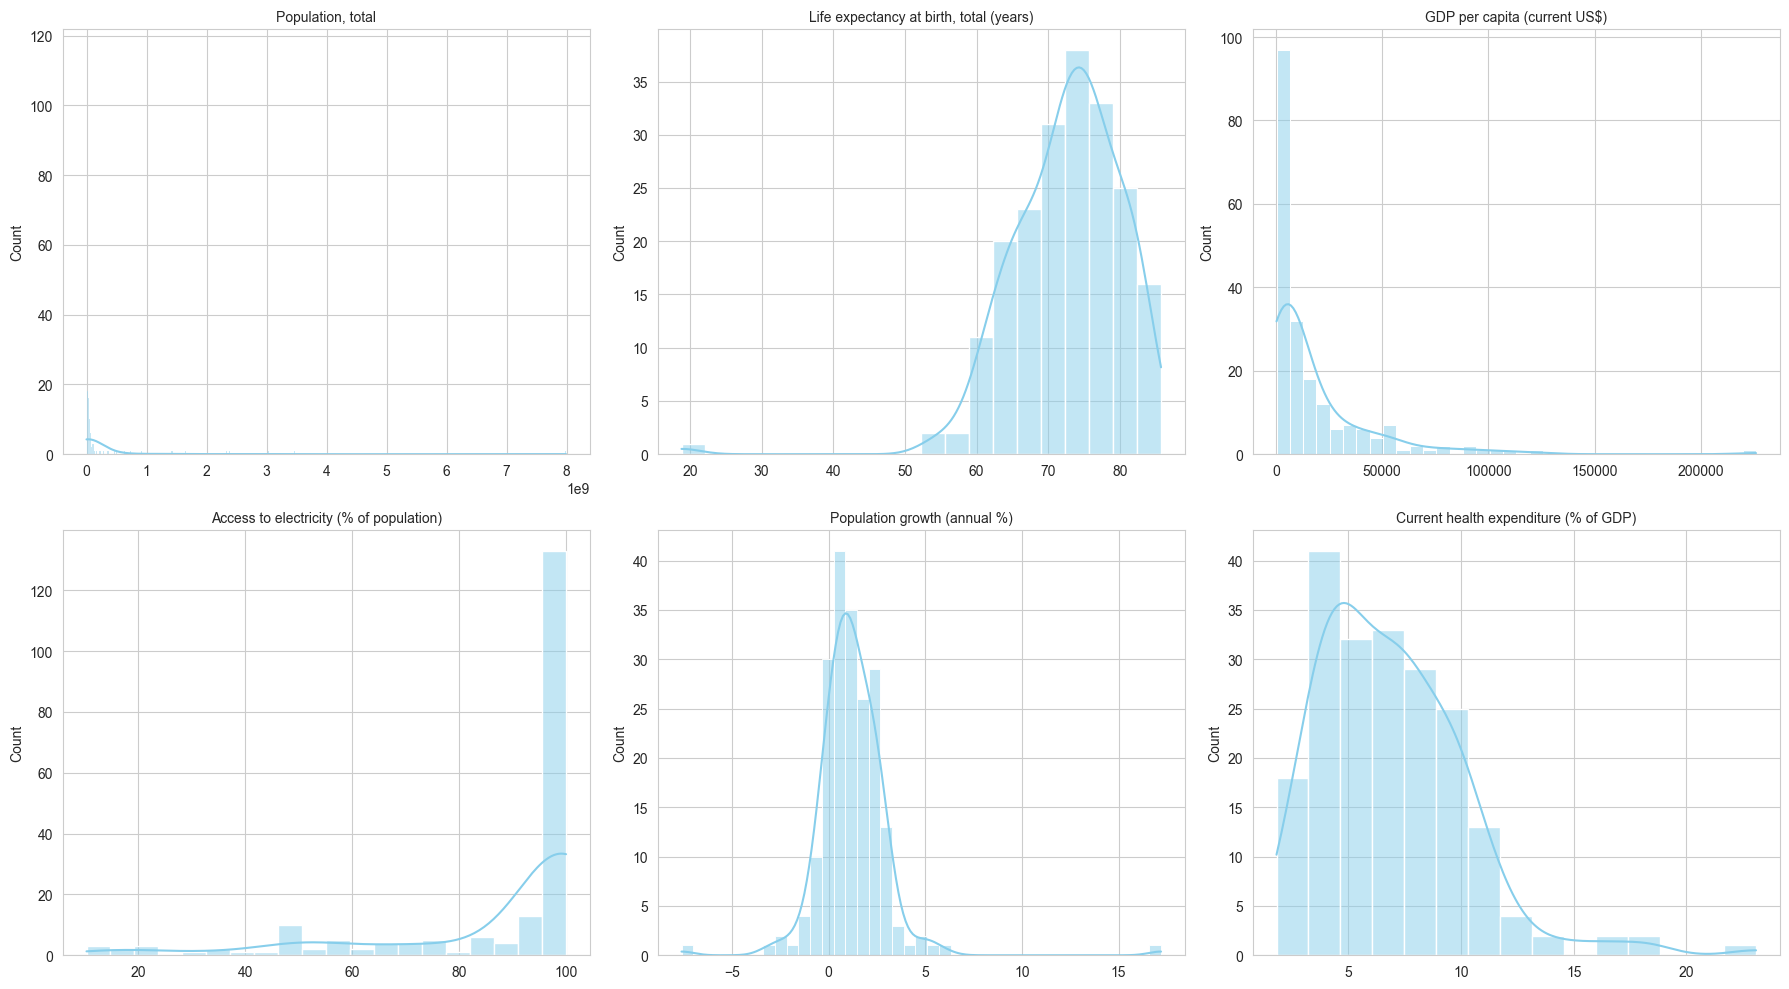

In [12]:
data_2022 = data[data["Year"] == 2022]
columns_to_plot = [
    'Population, total',
    'Life expectancy at birth, total (years)',
    'GDP per capita (current US$)',
    'Access to electricity (% of population)',
    'Population growth (annual %)',
    'Current health expenditure (% of GDP)'
]

sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(data_2022[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'{col}', fontsize=10)
    axes[i].set_xlabel('') 

plt.tight_layout()
plt.show()

## Section 4: Data Modeling

At first, we will split data for X, the matrix containing explanatory variables and y, target value, which is life expectancy. Secondly, we will split data for training and test. In our case, we can't split data randomly, the aproach we will use is that training data will be data until 2019 and test will be after 2019

In [13]:
target_col = 'Life expectancy at birth, total (years)'
features_to_drop = ['Country Name','empty_values',target_col]

X = data.drop(columns=features_to_drop)
y = data[target_col]


X_train = X[X['Year'] < 2019]
y_train = y[X['Year'] < 2019]

X_test = X[X['Year'] >= 2019]
y_test = y[X['Year'] >= 2019]


print(f"Training size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Training size: (3838, 6)
Test size: (808, 6)


We will use three models for modeling. 
1. Linear Regression
2. Decision Tree
3. Random Forest

In [17]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest random parameters": RandomForestRegressor(n_estimators=100, random_state=42)
}

Now we are creating pipeline, where we standarize our data and fit to the model. We also using cross-validation for better error estimation.

In [18]:
results = []

print(f"{'Model':<20} | {'CV RMSE':<10} | {'CV R2':<10}")
print("-" * 75)

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('regressor', model)
    ])
    
    cv_rmse_scores = -cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error')
    cv_r2_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='r2')
    
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_r2_mean = cv_r2_scores.mean()

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    results.append({
        'Model': name, 
        'RMSE': round(cv_rmse_mean, 4), 
        'R2': round(cv_r2_mean, 4),
    })
    
    print(f"{name:<20} | {cv_rmse_mean:<10.4f} | {cv_r2_mean:<10.4f}")
results_df = pd.DataFrame(results)



Model                | CV RMSE    | CV R2     
---------------------------------------------------------------------------
Linear Regression    | 4.2770     | 0.7545    
Decision Tree        | 4.9073     | 0.6849    
Random Forest random parameters | 3.7832     | 0.8086    


The best model is Random Forest. Let's train it one more time, but this time we will use Grid Search for hiperparameters tuning

In [19]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),                
    ('regressor', RandomForestRegressor(random_state=42))
])


param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid,
    cv=3,              
    n_jobs=-1,         
    scoring='r2',        
    verbose=1          
)

grid_search.fit(X_train, y_train)

print("\n--- Best parameters ---")
print(grid_search.best_params_)

print("\n--- Best score (R2) ---")
print(f"{grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Test set results ---")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits

--- Best parameters ---
{'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 50}

--- Best score (R2) ---
0.8117

--- Test set results ---
RMSE: 3.1471
R2 Score: 0.8286


In [21]:
results_df.loc[len(results_df)] = ['Random Forest tuned parameters', 3.1471, 0.8286]
results_df

,Model,RMSE,R2
0,Linear Regression,4.2770,0.7545
1,Decision Tree,4.9073,0.6849
2,Random Forest random parameters,3.7832,0.8086
3,Random Forest tuned parameters,3.1439,0.8289
4,Random Forest tuned parameters,3.1471,0.8286


## Section 5: Evaluation

In this section, we will use our data to answer the questions.

### Question 1: What is life expectancy throughout the years for selected countries? 

Let's visualize 

In [25]:
countries = ["China", "India","European Union", "United States", "Indonesia", "Pakistan", "Nigeria", "Brazil", "Bangladesh", "Russian Federation", "Mexico", "Switzerland", "Afghanistan"]
data_to_vis = data[data["Country Name"].isin(countries)]
regions = ["World","Early-demographic dividend","Lower middle income","East Asia & Pacific","Late-demographic dividend","South Asia","Sub-Saharan Africa", "Europe & Central Asia",
           "Middle East, North Africa, Afghanistan & Pakistan","Africa Eastern and Southern","Africa Western and Central","Arab World", "Euro area",
           "European Union","Latin America & the Caribbean (IDA & IBRD countries)", "North America"]
data_2022 = data_2022[~data_2022["Country Name"].isin(regions)]

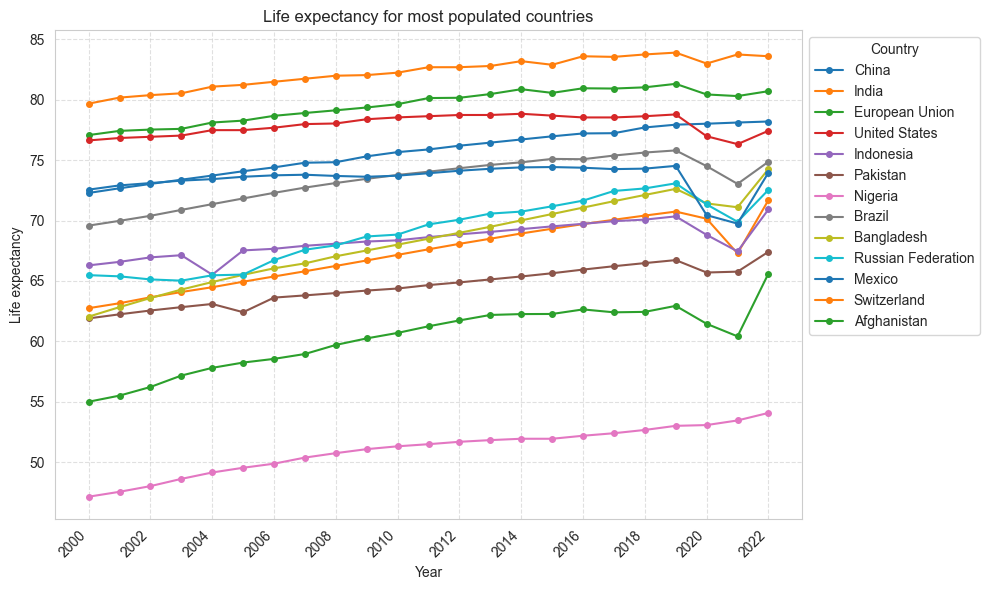

In [27]:
plt.figure(figsize=(10, 6))

for country in countries:
    df_country = data_to_vis[data_to_vis['Country Name'] == country]
    plt.plot(df_country['Year'], df_country['Life expectancy at birth, total (years)'], label=country, marker='o', markersize=4)

plt.xlabel('Year')
plt.ylabel('Life expectancy')
plt.title('Life expectancy for most populated countries')
plt.legend(title='Country', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(data_to_vis['Year'].unique()[::2], rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)

On the chart we can see how life expectancy for selected countries was behaving throughout years. The highest life expectancy can we observed in Switzerland and the lowest in Nigeria. They differ for almost 30 years. The second longest life expectancy we can see in European Union and third was USA until 2019, when China took a lead and become third country.

### Question 2: What is the relation between the life expectancy and GDP per capita?

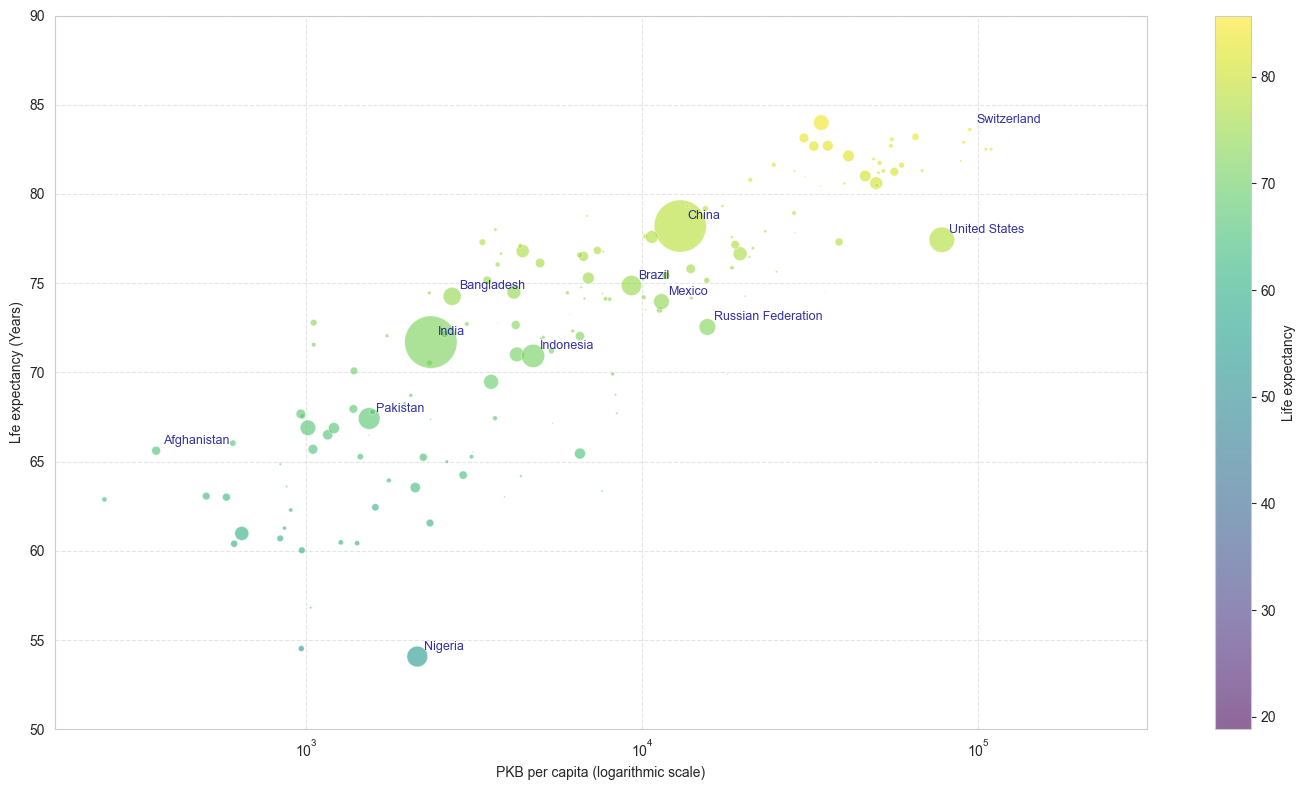

In [28]:
bubble_scale = 1000000 
point_size = data_2022['Population, total'] / bubble_scale

plt.figure(figsize=(18, 8))

plt.xscale('log')
scatter = plt.scatter(
    x = data_2022['GDP per capita (current US$)'], 
    y = data_2022['Life expectancy at birth, total (years)'], 
    s = point_size,  
    alpha=0.6,        
    c=data_2022['Life expectancy at birth, total (years)'], 
    cmap='viridis',   
    edgecolors='w',     
    linewidth=0.5
)

for i, row in data_2022[data_2022["Country Name"].isin(countries)].iterrows():
    x_coord = row['GDP per capita (current US$)']
    y_coord = row['Life expectancy at birth, total (years)']
    country_label = row['Country Name'] 
    plt.annotate(country_label, 
                 (x_coord, y_coord),
                 xytext=(5, 5), 
                 textcoords='offset points',
                 fontsize=9,    
                 alpha=0.8,
                 color = "darkblue")

plt.xlabel('PKB per capita (logarithmic scale)')
plt.ylabel('Lfe expectancy (Years)')
plt.ylim(50,90)

cbar = plt.colorbar(scatter)
cbar.set_label('Life expectancy')


plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

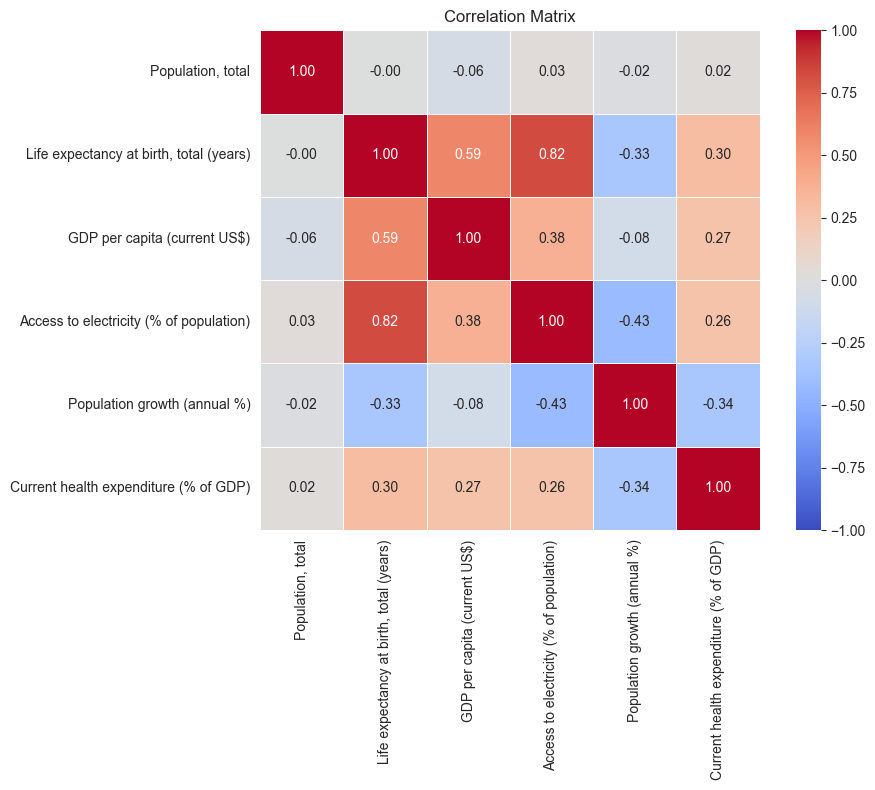

In [22]:
correlation_matrix = data[columns_to_plot].corr()
plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix, 
    annot=True,      
    fmt=".2f",        
    cmap='coolwarm',   
    vmin=-1, vmax=1,   
    linewidths=0.5,    
    square=True         
)

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

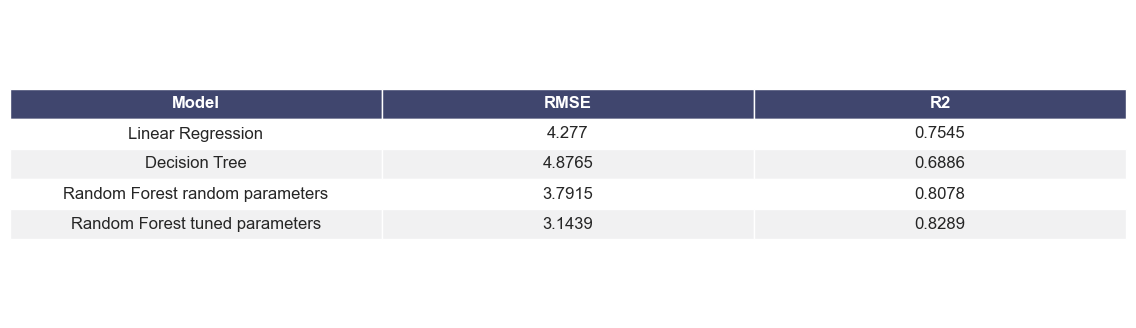

In [40]:
fig, ax = plt.subplots(figsize=(12, 4)) 
ax.axis('tight')
ax.axis('off')
header_color = '#40466e'
row_colors = ['#f1f1f2', 'w']
edge_color = 'w'

table = ax.table(
    cellText=results_df.values, 
    colLabels=results_df.columns, 
    loc='center', 
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.8)
for k, cell in table.get_celld().items():
    cell.set_edgecolor(edge_color)
    if k[0] == 0:
        cell.set_text_props(weight='bold', color='w')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors[k[0] % len(row_colors)])

plt.show()

We will train base model with only one training feature, the most correlated one with target value to see how 1-dim regression is doing.

In [50]:
X_train = X_train[["Access to electricity (% of population)"]]
X_test = X_test[["Access to electricity (% of population)"]]

grid_search.fit(X_train, y_train)

print("\n--- Best parameters ---")
print(grid_search.best_params_)

print("\n--- Best score (R2) ---")
print(f"{grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Test set results ---")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits

--- Best parameters ---
{'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}

--- Best score (R2) ---
0.7352

--- Test set results ---
RMSE: 4.9766
R2 Score: 0.5715


1-dim Regression is much worse than using whole set.

To summarize our final model used with cv has RMSE = 3.1449 which is fine, because the target value mean is equal to 69.83, so relative error is 4.5%

We saw on chart that there is strong linearity between log of gdp per capita and life expectancy, so let's model on log of gdp per capita

In [102]:
data['GDP per capita (current US$)'] = pd.to_numeric(
    data['GDP per capita (current US$)'], 
    errors='coerce'
)
data['GDP per capita (current US$)'] = np.log(data['GDP per capita (current US$)'])

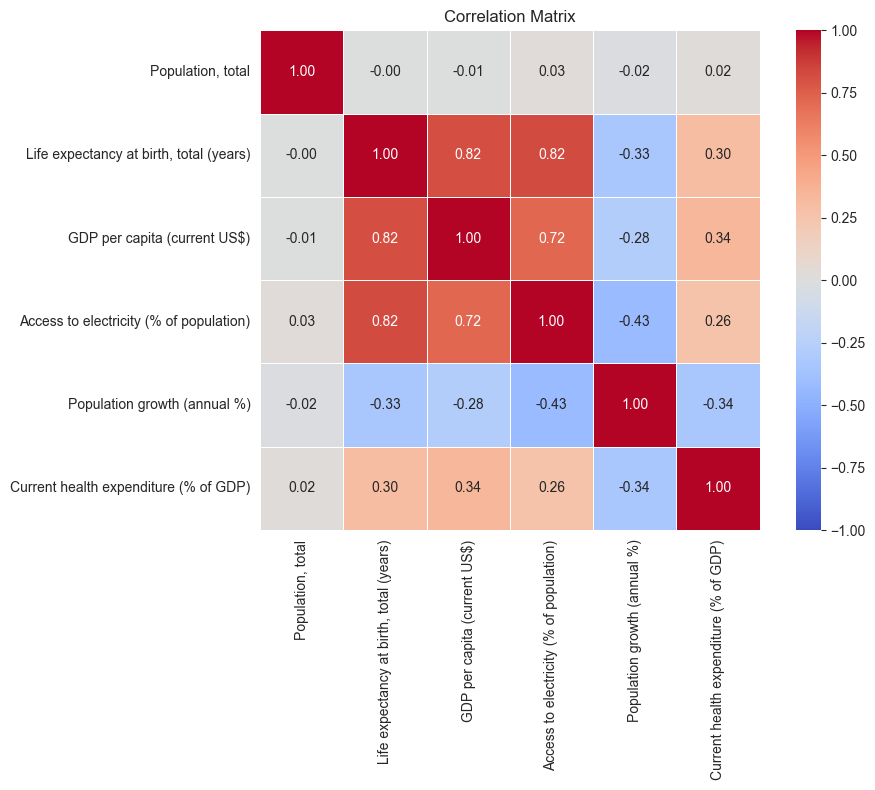

In [103]:
correlation_matrix = data[columns_to_plot].corr()
plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix, 
    annot=True,      
    fmt=".2f",        
    cmap='coolwarm',   
    vmin=-1, vmax=1,   
    linewidths=0.5,    
    square=True         
)

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Correlation is now higher between life expectancy and GDP per capita